# NasNet Template

### Setup

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.conv_learner import *
from fastai.plots import *
assert torch.cuda.is_available()
assert torch.backends.cudnn.enabled

import pathlib
import multiprocessing as mp
from sklearn.metrics import confusion_matrix

### Define utility functions

In [2]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)

def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = ["Predicted: %s (%.4f)\nTruth: %s" % (data.classes[preds[x]], np.max(probs[x,:]), data.classes[data.val_y[x]]) for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(28,10))      

def sort_by_correct(is_correct, n=4):   
    bools = (preds == data.val_y)==is_correct 
    pairs = list(zip(bools, np.max(probs,axis=1))) 
    p = np.array([i[1] if i[0]==True else 0 for i in pairs])         
    tops = p.argsort()[::-1][:n]
    return tops

def most_uncertain(n=4): return np.max(probs,axis=1).argsort()[:n]

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def most_by_mask(mask):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(probs[idxs])[:4]]

def most_by_correct(is_correct): 
    return most_by_mask((preds == data.val_y)==is_correct)

### Get data

In [3]:
PATH = '/root/data/sar_cars/'

### Inspect, load and augment data

In [4]:
TRAIN_PATH = os.path.join(PATH,'train')
os.listdir(TRAIN_PATH)[:3]
full_train = glob(os.path.join(TRAIN_PATH, '*.png'))

['PH_fcara1_0214_100deg_az.png',
 'PH_fcara1_0214_103deg_az.png',
 'PH_fcara1_0214_105deg_az.png']

#### Take a look

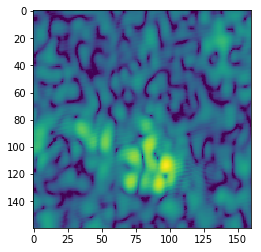

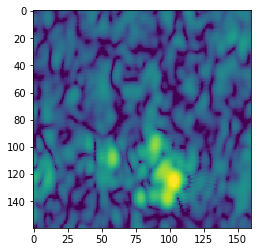

In [23]:
for i in range(2):
    img = plt.imread(full_train[i]);
    plt.figure();
    plt.imshow(img);
plt.show();

In [5]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv)))-1
assert len(full_train) == n
val_idxs = get_cv_idxs(n)

def get_data(sz,bs=64):
    stats = ([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    tfms = tfms_from_stats(stats, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    return ImageClassifierData.from_csv(PATH, 'train', label_csv, tfms=tfms,
                    suffix='.png', val_idxs=val_idxs, bs=bs)

In [8]:
data = get_data(160,4)
                
# stats
len(data.trn_ds), len(data.val_ds)
len(data.classes)
data.classes
data.val_y[:5]

# class numbers
labels_df = pd.read_csv(label_csv)
labels_df.pivot_table(index='car', aggfunc=len).sort_values('id', ascending=False)

(49868, 12467)

6

['Chevrolet_HHR_LT',
 'Chevrolet_Impala_LT',
 'Chrysler_Town_&_Country',
 'Mitsubishi_Galant_ES',
 'Pontiac_Torrent',
 'Toyota_Highlander']

array([1, 1, 1, 1, 1])

,id
car,
Toyota_Highlander,13854
Pontiac_Torrent,11547
Chrysler_Town_&_Country,11543
Chevrolet_HHR_LT,11542
Chevrolet_Impala_LT,6925
Mitsubishi_Galant_ES,6924


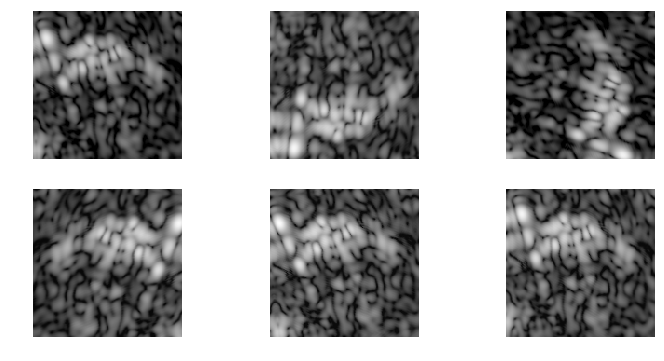

In [26]:
# show data augmentations examples used to reduce overfitting/improve generalization
def get_augs(data, ix=0):
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[ix]

ims = np.stack([get_augs(data, ix=0) for i in range(6)])
plots(ims, rows=2)

## Begin modeling

In [27]:
# Uncomment the below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [7]:
def nasnet(pre): return nasnetalarge(pretrained = 'imagenet' if pre else None)
model_features[nasnet]=4032*2
arch=nasnet

### Choose a learning rate
Gradually increase learning rate from very small value until loss stops decreasing, in order to find learning rate that improves loss most quickly (lowest slope, and round up, since this will be the MAX rate used after adding additional learning rates later)

In [29]:
# Precompute activation functions (also freezes all but last layer)
learn = ConvLearner.pretrained(arch, data, precompute=True, xtra_fc=[], ps=0.5)

/opt/conda/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


 52%|█████████████████████████████████████▉                                   | 3235/6234 [00:11<00:10, 293.52it/s, loss=6.48]

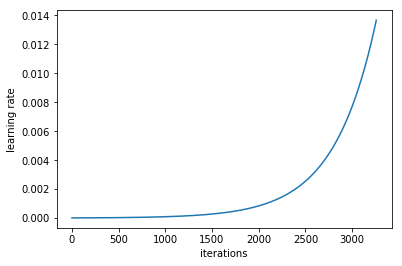

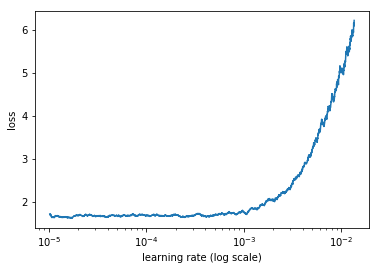

In [41]:
lrf=learn.lr_find()
# look at the learning rate schedule
learn.sched.plot_lr()
plt.show();
learn.sched.plot()
plt.show();

The loss is still clearly improving at lr=1e-2 (0.01), so that's what we use. Note that the optimal learning rate can change as we train the model, so you may want to re-run this function from time to time.

### Train final layer with caching of frozen layers for speed

In [42]:
%time
learn.fit(1e-4, n_cycle=20, cycle_len=1, cycle_mult=1)
#learn.fit(1e-2, n_cycle=10, cycle_len=1, cycle_mult=1)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.78 µs


epoch      trn_loss   val_loss   accuracy   
    0      1.637251   2.125566   0.292452  
    1      1.663246   2.346103   0.290607  
    2      1.641868   2.391144   0.288602  
    3      1.693586   2.153968   0.297265  
    4      1.681      2.059094   0.301275  
    5      1.645669   2.267082   0.285955  
    6      1.681806   1.999009   0.290687  
    7      1.650325   2.314411   0.292853  
    8      1.645022   2.167829   0.293174  
 78%|████████████████████████████████████████████████████████▌                | 4834/6234 [00:16<00:04, 291.80it/s, loss=1.68]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    19     1.621045   2.590977   0.289725  


[2.5909769419077797, 0.28972487366887]

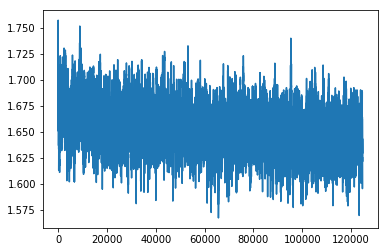

In [43]:
learn.sched.plot_loss()

In [44]:
learn.save('nas_pre')

In [45]:
learn.load('nas_pre')

#### check current validation results

In [46]:
# predict on validation set (in log scale)
log_preds = learn.predict()
log_preds.shape
preds = np.argmax(log_preds, axis=1)  # from log probabilities to integer class mappings
probs = np.exp(log_preds)        # probability of each breed
preds[:10]

from sklearn.metrics import log_loss
log_loss(data.val_y, probs)

(12467, 6)

array([0, 0, 5, 0, 4, 3, 3, 4, 0, 5])

2.422030275942249

Correctly classified


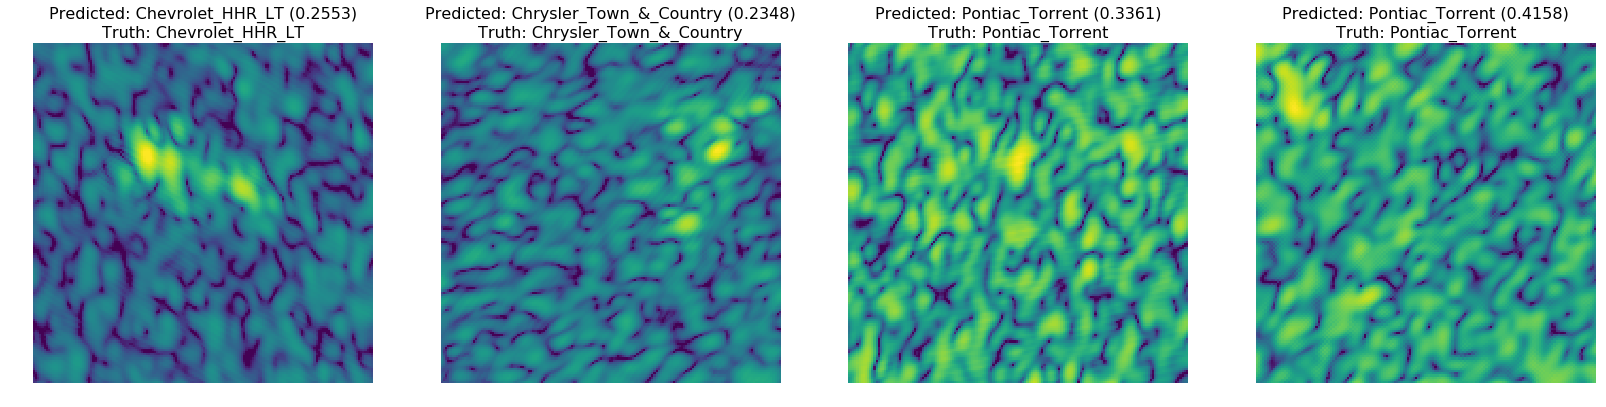

In [47]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


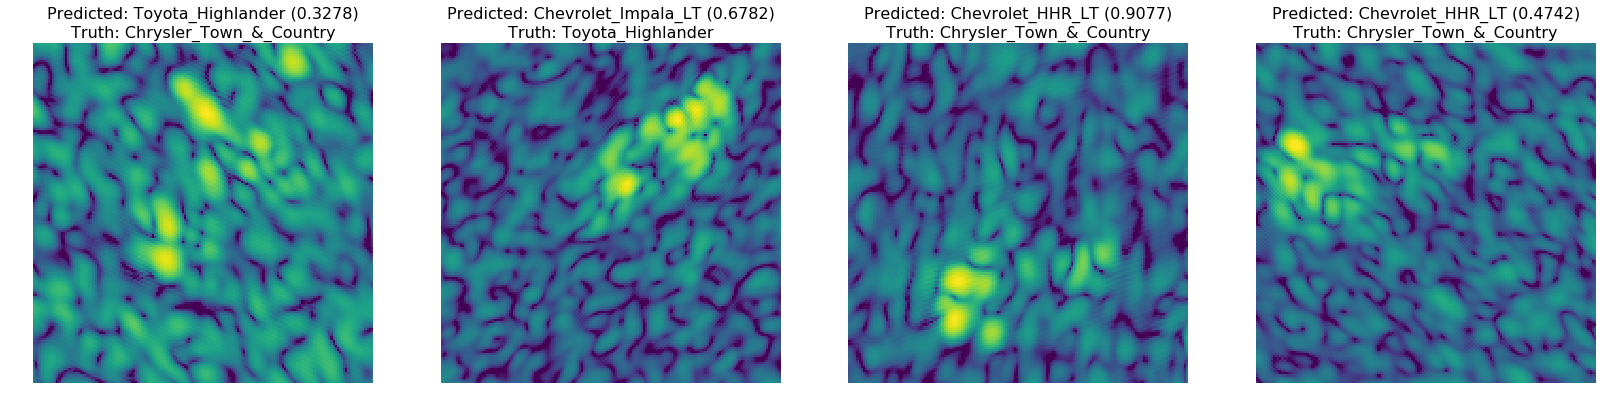

In [48]:
# 2. A few incorrect labels at random
# Remember, square center is cropped, so vital information existing on edges could cause misclassification!s
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

Most correctly classified


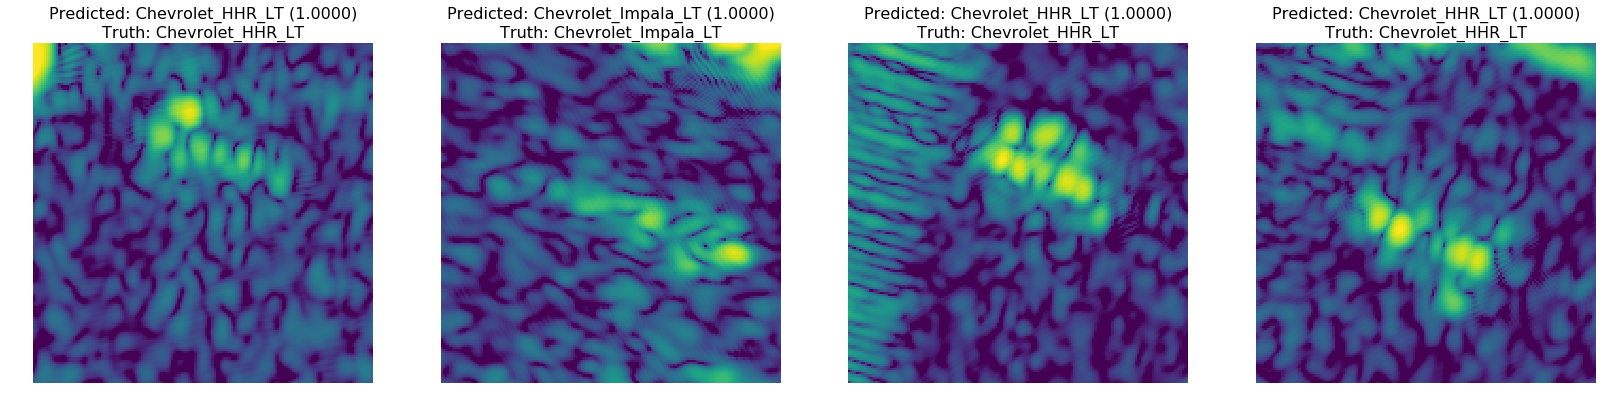

In [49]:
# 3. A few of the most correct labels
plot_val_with_title(sort_by_correct(True), "Most correctly classified")

Most incorrectly classified


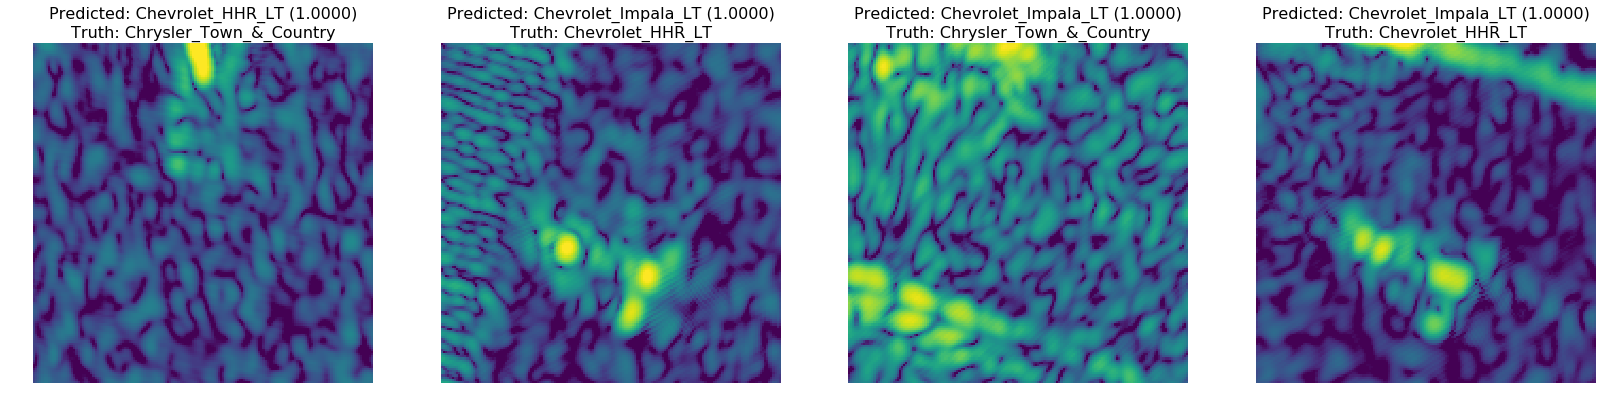

In [50]:
# 4. A few of the most incorrect labels
plot_val_with_title(sort_by_correct(False), "Most incorrectly classified")

Most uncertain predictions


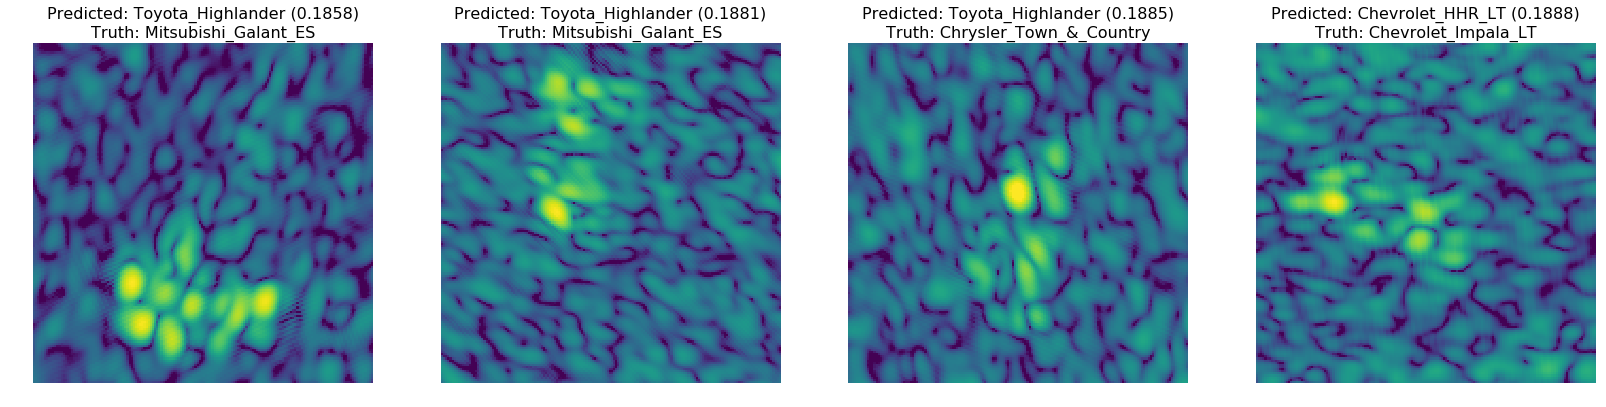

In [51]:
plot_val_with_title(most_uncertain(), "Most uncertain predictions")

### Turn off caching of frozen layers (to enable data augmentation), add SGDR (cyclic LR schedule), continue training final layer

In [52]:
lrf=learn.lr_find()

 52%|█████████████████████████████████████▉                                   | 3235/6234 [00:11<00:10, 292.59it/s, loss=6.35]

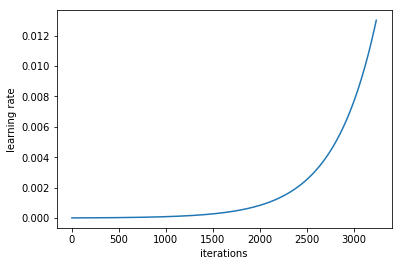

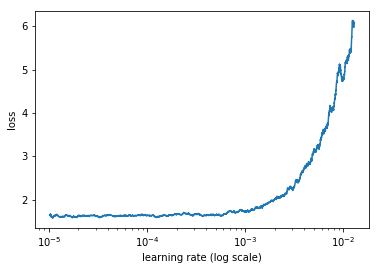

In [53]:
# look at the learning rate schedule
learn.sched.plot_lr()
plt.show();
# pick a rate
learn.sched.plot()
plt.show();

In [9]:
learn = ConvLearner.pretrained(arch, data, precompute=True, xtra_fc=[], ps=0.5)
learn.load('nas_pre')

/opt/conda/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [ ]:
%time
learn.precompute=False
learn.bn_freeze=True

learn.fit(1e-3, 3, cycle_len=1, cycle_mult=2)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 10.5 µs


epoch      trn_loss   val_loss   accuracy   
    0      1.798968   2.585121   0.254512  
    1      1.893706   2.867589   0.24609   


In [ ]:
learn.unfreeze()
learn.fit(1e-3, 20, cycle_len=2)

epoch      trn_loss   val_loss   accuracy   
    0      2.042444   4.464208   0.244887  
    1      1.835569   3.68347    0.243443  
    2      1.940759   5.530308   0.225235  
    3      1.811049   3.989654   0.245528  
    4      1.906013   4.108383   0.235582  
    5      1.791096   4.033369   0.244084  
    6      1.879157   4.906035   0.236224  


In [41]:
learn.set_data(get_data(160))

In [43]:
learn.unfreeze()
learn.fit([1e-5,1e-4,1e-3], 12, cycle_len=4, cycle_mult=2)

  0%|                                                                                                 | 0/780 [00:00<?, ?it/s]

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1525909934016/work/aten/src/THC/generic/THCStorage.cu:58

In [ ]:
learn.save('nas_frozen')
learn.sched.plot_loss()
plt.show();
learn.sched.plot_lr()
plt.show();

### Increase size

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=False, xtra_fc=[], ps=0.5)
learn.load('nas_frozen')
learn.set_data(get_data(299))

In [ ]:
# recheck optimal learning rate
lrf=learn.lr_find()
learn.sched.plot_lr()
plt.show();
learn.sched.plot()
plt.show();

In [ ]:
# reset lr every epoch, for 3 cycles total
learn.fit(1e-3, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save('nas_299')
learn.sched.plot_loss()
plt.show();
learn.sched.plot_lr()
plt.show();

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=False, xtra_fc=[], ps=0.5)
learn.load('nas_299')

In [ ]:
learn.set_data(get_data(320, 40))
learn.fit(5e-5, 5, cycle_len=1, cycle_mult=1)

In [ ]:
learn.save('nas_320')
learn.sched.plot_loss()
plt.show();
learn.sched.plot_lr()
plt.show();

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=False, xtra_fc=[], ps=0.5)
learn.load('nas_320')
learn.set_data(get_data(350, 32))
learn.fit(1e-4, 3, cycle_len=1, cycle_mult=2)
learn.save('nas_350')
learn.sched.plot_loss()
plt.show();
learn.sched.plot_lr()
plt.show();

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=False, xtra_fc=[], ps=0.5)
learn.load('nas_350')
learn.set_data(get_data(400, 16))
learn.fit(4e-4, 3, cycle_len=1, cycle_mult=2)
learn.save('nas_400')
learn.sched.plot_loss()
plt.show();
learn.sched.plot_lr()
plt.show();

In [ ]:
log_preds,y = learn.TTA(n_aug=9)
log_probs = log_preds
probs = np.mean(np.exp(log_probs),0)
preds = np.argmax(probs,axis=1)

accuracy_np(probs,y), metrics.log_loss(y,probs)

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=False, xtra_fc=[], ps=0.5)
learn.load('nas_400')
learn.set_data(get_data(450, 16))
learn.fit(5e-5, 3, cycle_len=1, cycle_mult=2)
learn.save('nas_450')
learn.sched.plot_loss()
plt.show();
learn.sched.plot_lr()
plt.show();

log_preds,y = learn.TTA(n_aug=9)
log_probs = log_preds
probs = np.mean(np.exp(log_probs),0)
preds = np.argmax(probs,axis=1)

accuracy_np(probs,y), metrics.log_loss(y,probs)

### Fine-tune other layers using differential learning rates and learning rate cycle multipler (to slow down resets as training progresses)

Final layer is now fully trained. Other layers have already been trained to recognize imagenet photos (whereas final layers were randomly initialized), so don't want to destroy the carefully tuned weights that are already there. The earlier layers (as we've seen) have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers. First, all layers up to layer 17 will be kept frozen. Then, the next few layers will be at 1e-5, the next few at 1e-4, and our FC layers we'll leave at 1e-2 as before.

In [ ]:
def freeze_to(m, n):
    c=children(m[0])
    for l in c:     set_trainable(l, False)
    for l in c[n:]: set_trainable(l, True)
        
freeze_to(learn.model, 12)

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=False, xtra_fc=[], ps=0.5)
learn.load('nas_450')
learn.set_data(get_data(450, 16))
learn.fit([1e-5,1e-4,1e-2], 3, cycle_len=1, cycle_mult=2)

learn.save('nas_fine')
learn.sched.plot_loss()
plt.show();
learn.sched.plot_lr()
plt.show();

log_preds,y = learn.TTA(n_aug=9)
log_probs = log_preds
probs = np.mean(np.exp(log_probs),0)
preds = np.argmax(probs,axis=1)

accuracy_np(probs,y), metrics.log_loss(y,probs)

Note: plot above is the final layers. Learning rates of earlier layers are set to fractions of the final layers rates.

### Check and analyze results on validation set using test time augmentation
Make predictions on a number of randomly augmented versions of validation set, then use the average prediction

In [ ]:
log_preds,y = learn.TTA()

In [ ]:
log_probs = log_preds
probs = np.mean(np.exp(log_probs),0)
preds = np.argmax(probs,axis=1)

accuracy_np(probs,y), metrics.log_loss(y,probs)

#cm = confusion_matrix(y, preds)
#plot_confusion_matrix(cm, data.classes)

### Looking at pictures again

In [ ]:
plot_val_with_title(sort_by_correct(True), "Most correctly classified")

In [ ]:
plot_val_with_title(sort_by_correct(False), "Most incorrectly classified")

### Compare validation results to other models
### If this model is best, retrain on full training set, predict on test set, submit

check submission example, format with kaggle

try using kaggle python api


should set above up so it renames train to full_train  
then COPIES to train/valid

In [ ]:
def get_data(sz):
    stats = ([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    tfms = tfms_from_stats(stats, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    return ImageClassifierData.from_csv(PATH, 'train', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=[0], test_name='test', bs=64)

data = get_data(450)
learn = ConvLearner.pretrained(arch, data, precompute=True, xtra_fc=[], ps=0.5)
learn.fit(1e-2, 5)
learn.precompute=False
learn.bn_freeze=True
learn.fit(1e-2, 5, cycle_len=1)
learn.set_data(get_data(500))
learn.fit(1e-2, 3, cycle_len=1)
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)
freeze_to(learn.model, 17)
learn.fit([1e-5,1e-4,1e-2], 3, cycle_len=1, cycle_mult=2)

In [ ]:
log_preds,y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds),0)
preds = np.argmax(probs,axis=1)

In [ ]:
!ls {PATH}